In [1]:
import json
import numpy as np
import pandas as pd
import h5py
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import random

In [2]:
data_dir = Path('../../data')
cello_dir = data_dir / f'CellO_data/bulk_RNA_seq_training_set'

## The goal of this project is to find B vectors(embeddings) having trained Z matrix and observation data

### Loading Y and Z and verifying we've got the right vectors
#### Y is a source data used for PLIER training. Y ≈ ZB

In [3]:
# transposing, so we have columns as features and rows as sample vectors
full_Y_df = pd.read_csv(data_dir / 'mat4.csv').transpose()
full_Y_df.shape

(4293, 55904)

In [4]:
with open(cello_dir / 'experiment_to_study.json', 'r') as f:
    exp2study = json.load(f)
full_df_studies = full_Y_df.index.map(exp2study)

In [5]:
train_studies = open(cello_dir / 'plier_train_studies.txt').read().strip().split(',')
len(train_studies)

237

In [6]:
train_Y_df = full_Y_df[full_df_studies.isin(train_studies)]
test_Y_df = full_Y_df[~full_df_studies.isin(train_studies)]
train_Y_df.shape, test_Y_df.shape

((3868, 55904), (425, 55904))

In [7]:
Z_df = pd.read_csv(data_dir / 'plierResult-train/Z.csv')
Z_mat = Z_df.values
Z_df.shape

(5900, 356)

#### Not all genes from original data(Y) present in Z matrix. Rest of the genes were droped by PLIER as less significant
Let's select only 5900 genes that present in matrix Z. Z is a vertical matrix with columns matching the dimensionality of our embedding vector and number of rows matching the number of genes used

In [8]:
Z_genes = Z_df.index
train_Y_df = train_Y_df[Z_genes]
test_Y_df = test_Y_df[Z_genes]

train_Y_df.shape

(3868, 5900)

#### Loading B matrix built on train data

In [9]:
# transposing, so we have columns as features and rows as sample vectors
B_df = pd.read_csv(data_dir / 'plierResult-train/B.csv').transpose()
B_df.shape

(3868, 356)

Making sure we've trained PLIER on train set

In [10]:
B_samples = B_df.index.values
train_samples = train_Y_df.index.values
assert set(B_samples) == set(train_samples)
assert sum(B_samples != train_samples) == 0

In [11]:
# store samples associated with target embeddings
target_y_vectors = test_Y_df.values

# computing normalization values on train dataset
per_gene_mean = train_Y_df.mean().values
per_gene_std = train_Y_df.std().values

target_y_vectors = (target_y_vectors - per_gene_mean) / per_gene_std

target_y_vectors.shape

(425, 5900)

## Using regression to find the B that will produce vectors close to test Y

In [12]:
from numpy.linalg import inv

In [13]:
X = Z_mat

# linear least squares
# check this for more details: https://machinelearningmastery.com/solve-linear-regression-using-linear-algebra/
b_test = inv(X.T.dot(X)).dot(X.T).dot(target_y_vectors.T)
b_test.shape

(356, 425)

#### Let's try to compare source Y vales to values reconstructed using Z and reconstructed B

In [14]:
y_test_hat = Z_mat.dot(b_test).transpose()
y_test_hat.shape

(425, 5900)

<AxesSubplot:>

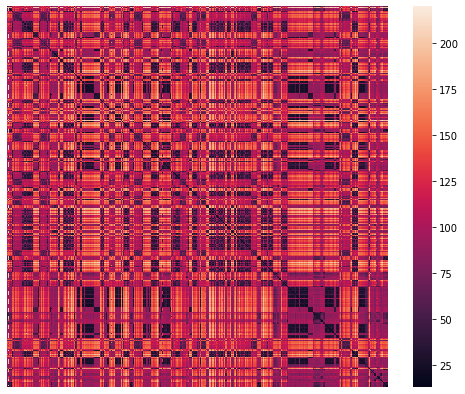

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

y2y_hat_dists = scipy.spatial.distance.cdist(target_y_vectors, y_test_hat)
sns.heatmap(y2y_hat_dists,
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

### Using Pearson correlation as a distance

In [16]:
def pearson_dists(vectors_a, vectors_b):
    vectors_pairs = zip(vectors_a, vectors_b)
    return [scipy.spatial.distance.correlation(a, b) for a, b in vectors_pairs]

In [17]:
y2y_hat_dists = pearson_dists(target_y_vectors, y_test_hat)
y2y_random_dists = pearson_dists(
    target_y_vectors, 
    random.sample(target_y_vectors.tolist(), len(target_y_vectors))
)

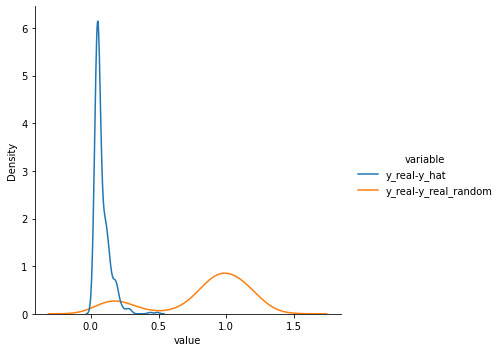

In [18]:
dists_df = pd.DataFrame({
    'y_real-y_hat': y2y_hat_dists,
    'y_real-y_real_random': y2y_random_dists
})

sns.displot(
    data=pd.melt(dists_df, value_vars=['y_real-y_hat', 'y_real-y_real_random']), 
    x='value', hue='variable', kind='kde')

### Existing Z matrix does great job embedding the test data

## Looking at closest samples

In [19]:
import sys
sys.path.append('../../onto_lib')

In [20]:
from anndata import AnnData
import scanpy as sc
import json
import general_ontology_tools as got

Unable to import pygraphviz. Visualization is disabled.
Loading ontology from ../../onto_lib\obo\DOID.17-01-30.obo ...
Loading ontology from ../../onto_lib\obo\UBERON.17-01-30.obo ...
Loading ontology from ../../onto_lib\obo\CL.18-11-13.obo ...
Loading ontology from ../../onto_lib\obo\CVCL.17-01-30.obo ...
Loading ontology from ../../onto_lib\obo\EFO.17-01-30.obo ...


In [21]:
with open(data_dir / 'CellO_data/bulk_RNA_seq_training_set/bulk_labels.json', 'r') as f:
    sample2cell_types_ids = json.load(f)

In [22]:
sample2types = {
    sample: list(map(got.get_term_name, types_ids))
    for sample, types_ids in sample2cell_types_ids.items()
}

### Plotting

In [23]:
test_b_vectors = b_test.T
test_samples = test_Y_df.index.values

In [28]:
b_test_df = pd.DataFrame(test_b_vectors)
b_test_df.index = test_samples
b_test_df.columns = B_df.columns
b_test_df.shape

(425, 356)

In [29]:
B_full = pd.concat([B_df, b_test_df])
B_full.shape

(4293, 356)

In [30]:
ad = AnnData(B_full)

In [31]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
types_per_b_samples = B_full.index.map(sample2types).values

# pd.DataFrame(mlb.fit_transform(s)
             
# B_full_ctypes = B_full.index.map(sample2types)
types_dummies = pd.DataFrame(mlb.fit_transform(types_per_b_samples), columns=mlb.classes_, index=B_full.index)
types_dummies.shape

(4293, 317)

In [33]:
# Gather all of the cell types
all_cell_types = set()
for cts in sample2types.values():
    all_cell_types.update(cts)

In [34]:
cts_per_samples = [
    sample2types[sample]
    for sample in ad.obs.index
]

In [35]:
test_mask = B_full.index.isin(test_samples)

In [56]:
# Add cell type annotations to AnnData object
for ct in types_dummies.columns:
    ad.obs[ct] = types_dummies[ct].values
    ad.obs[ct + ' - test'] = (types_dummies[ct].values & test_mask).astype(str)
    ad.obs[ct + ' - train'] = (types_dummies[ct].values & ~test_mask).astype(str)

In [67]:
top_train_types = types_dummies[test_mask].sum().sort_values(ascending=False)[15:45]
top_train_types

haploid cell                            76
male gamete                             76
gamete                                  76
male germ cell                          76
leukocyte                               62
nucleate cell                           59
precursor cell                          56
nongranular leukocyte                   52
single nucleate cell                    52
mononuclear cell                        52
myeloid cell                            49
bone cell                               40
myeloid leukocyte                       40
non-terminally differentiated cell      31
connective tissue cell                  31
osteoblast                              31
circulating cell                        24
peripheral blood mononuclear cell       24
defensive cell                          22
lymphocyte                              21
T cell                                  18
professional antigen presenting cell    18
mature alpha-beta T cell                17
mature T ce

In [62]:
# Compute UMAP
sc.pp.pca(ad)
sc.pp.neighbors(ad)
sc.tl.umap(ad)

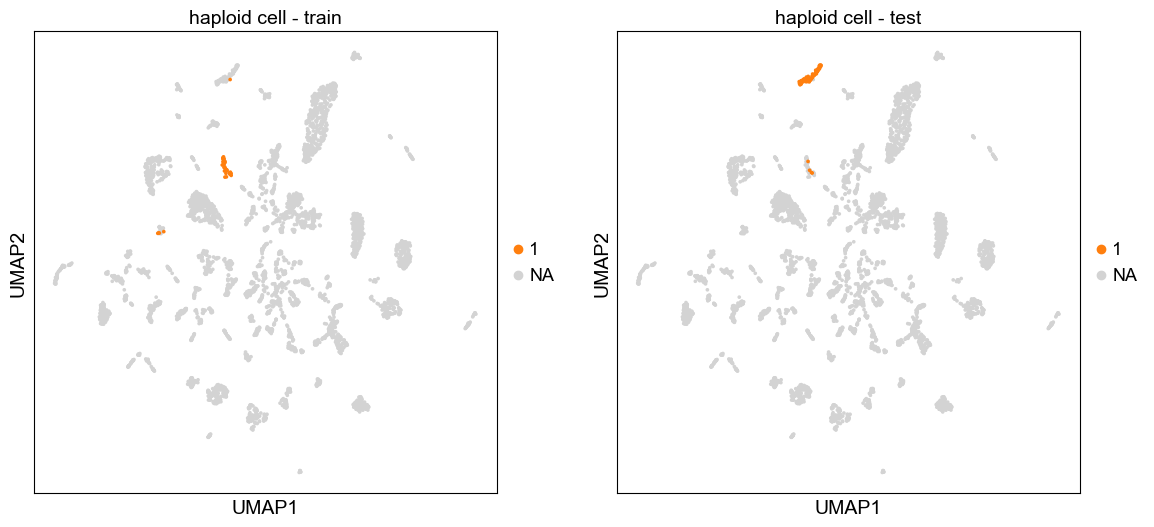

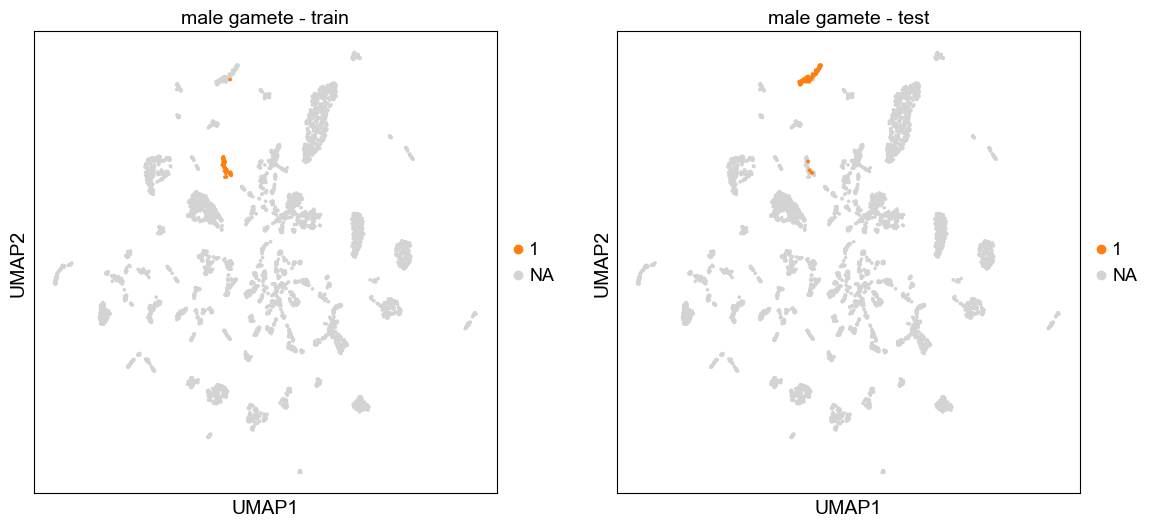

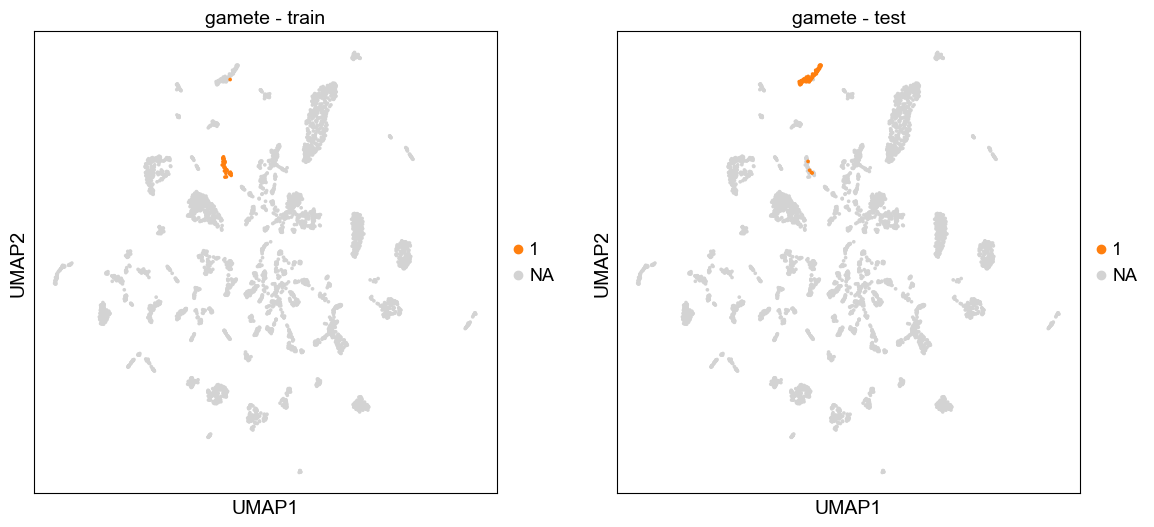

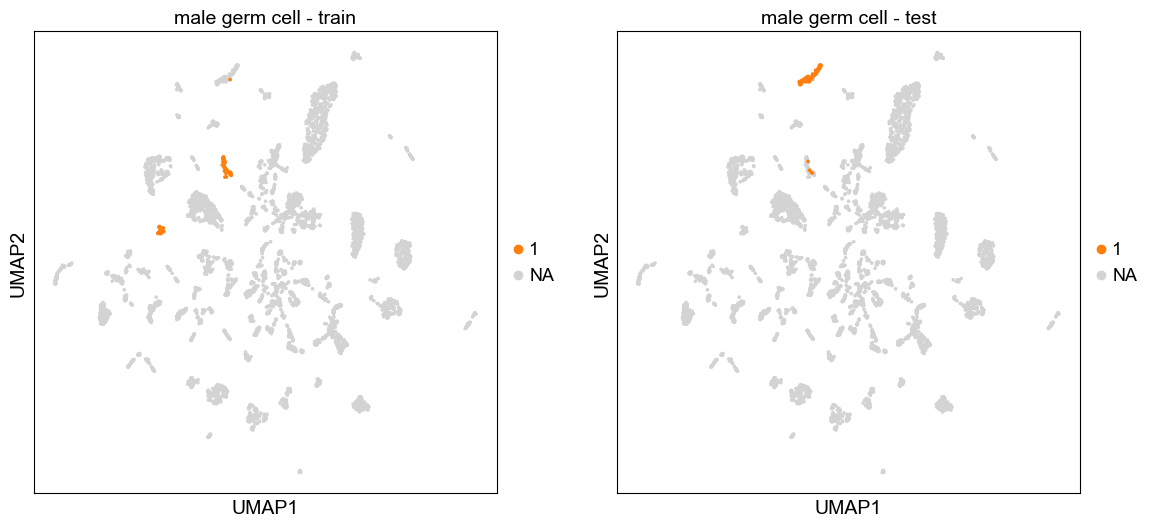

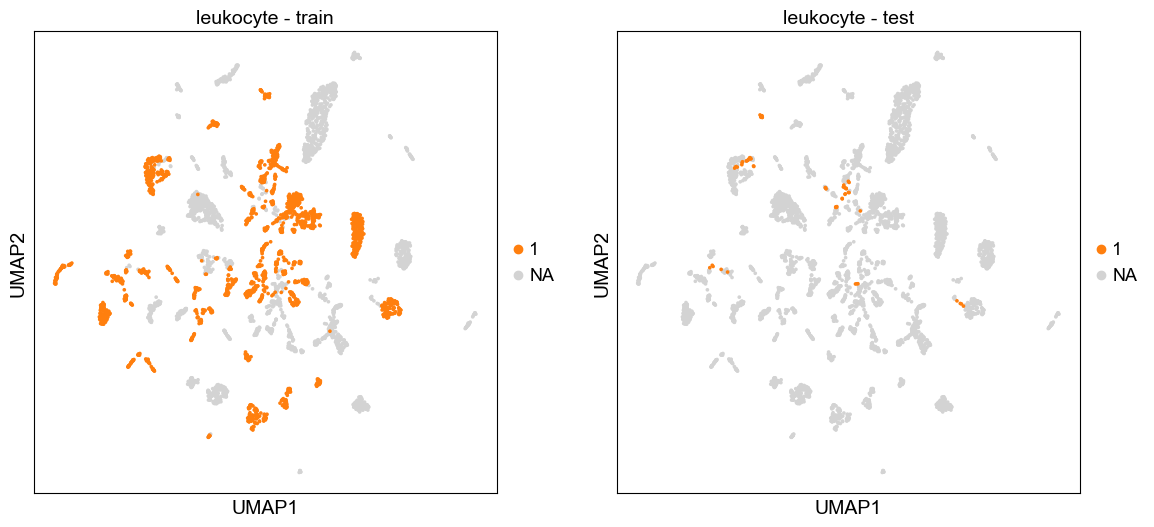

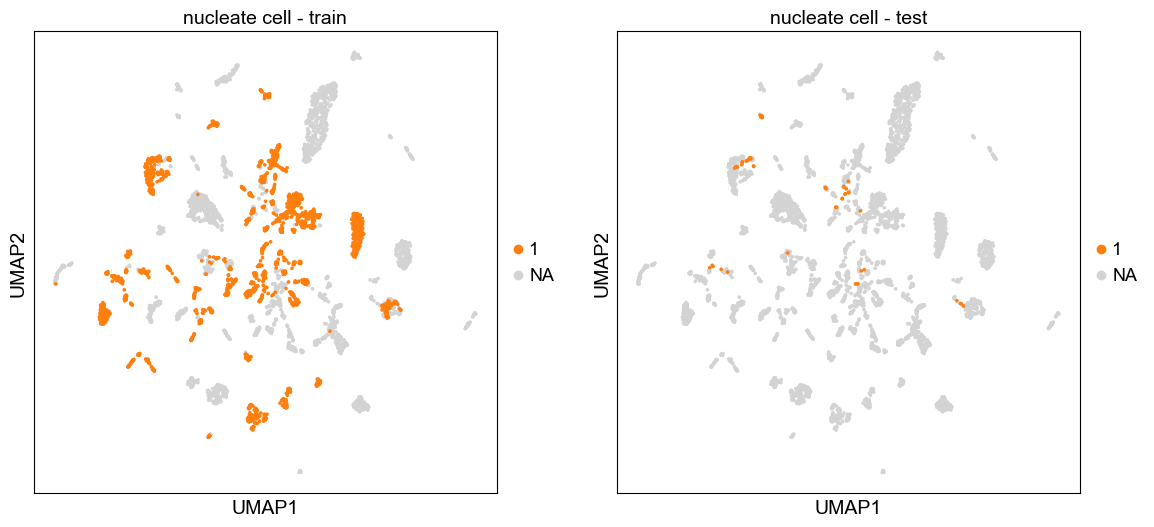

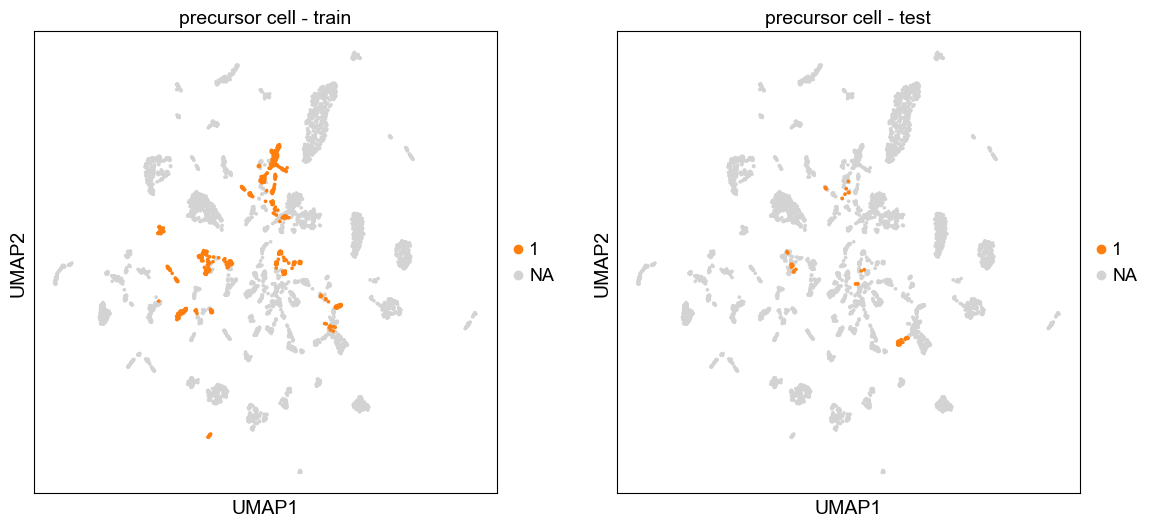

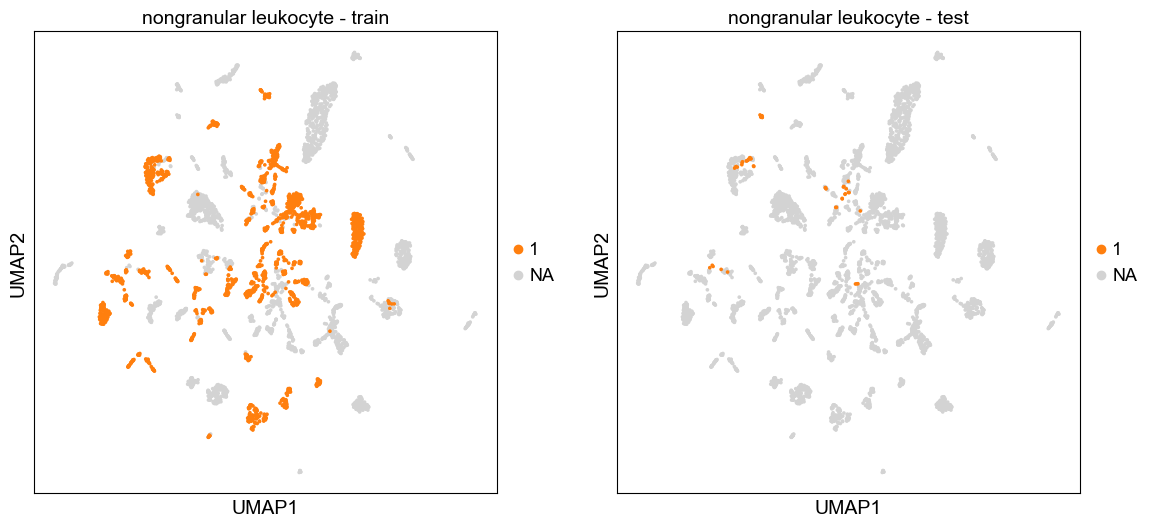

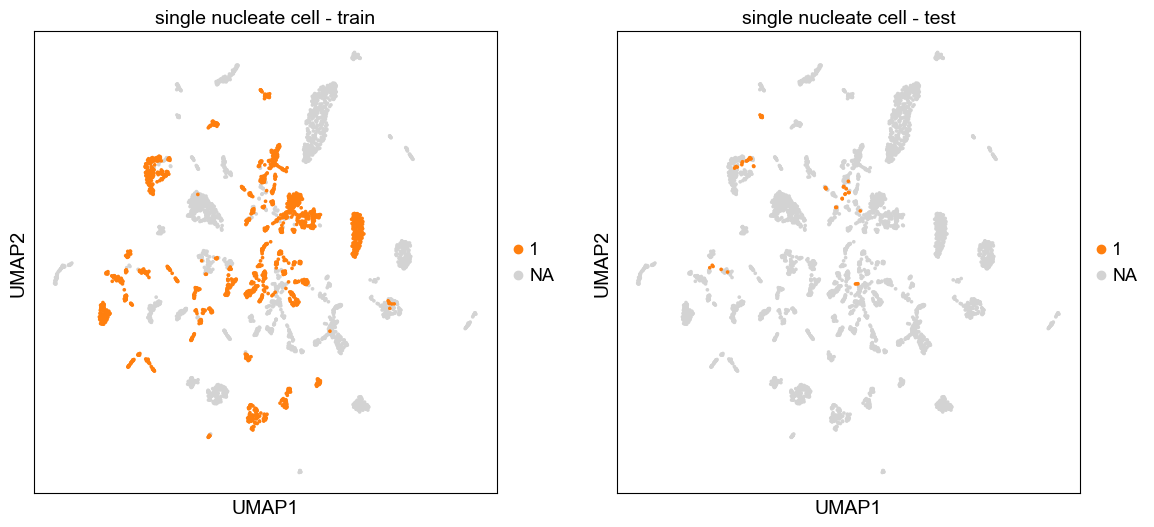

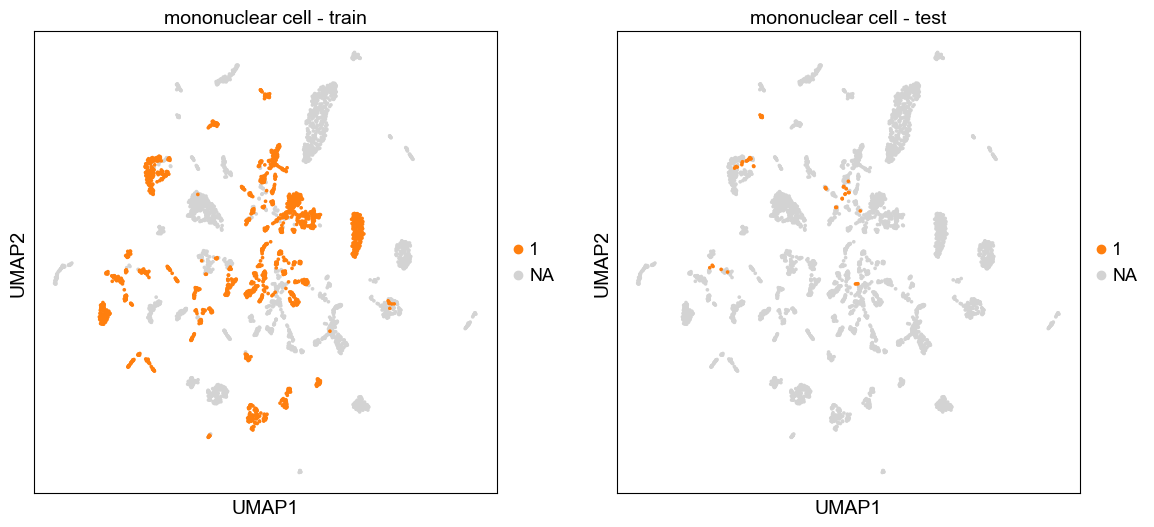

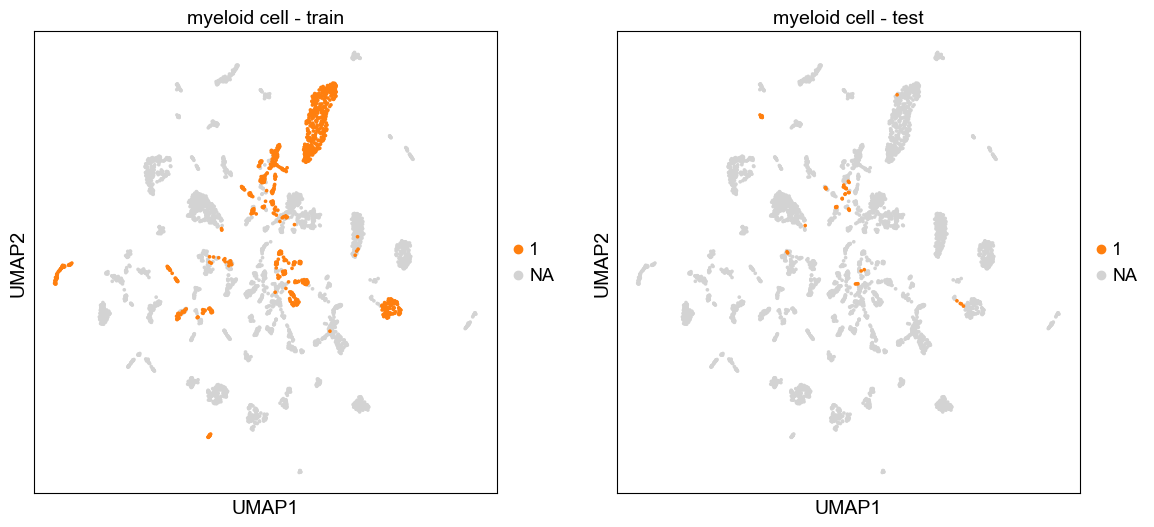

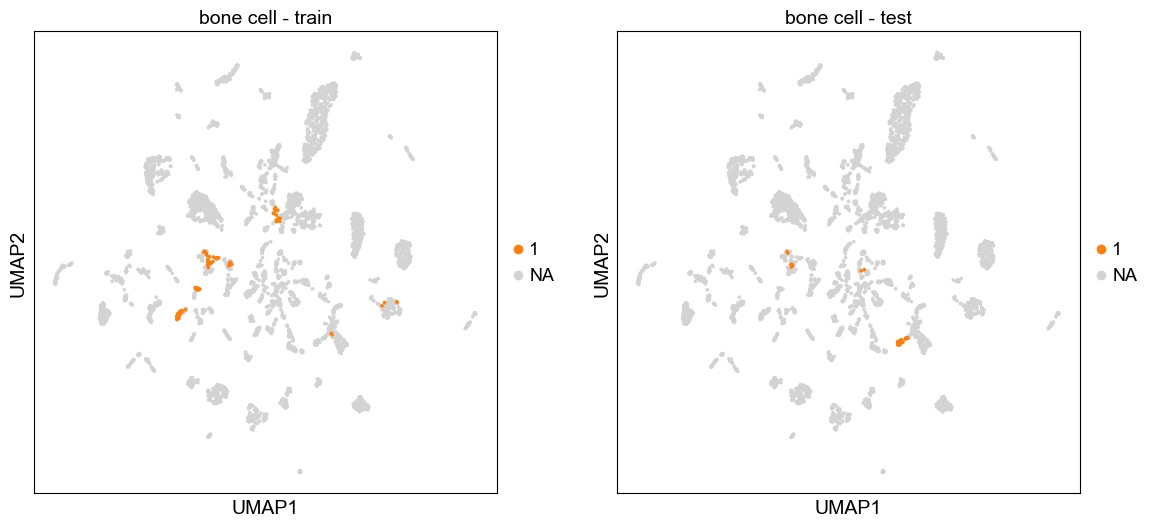

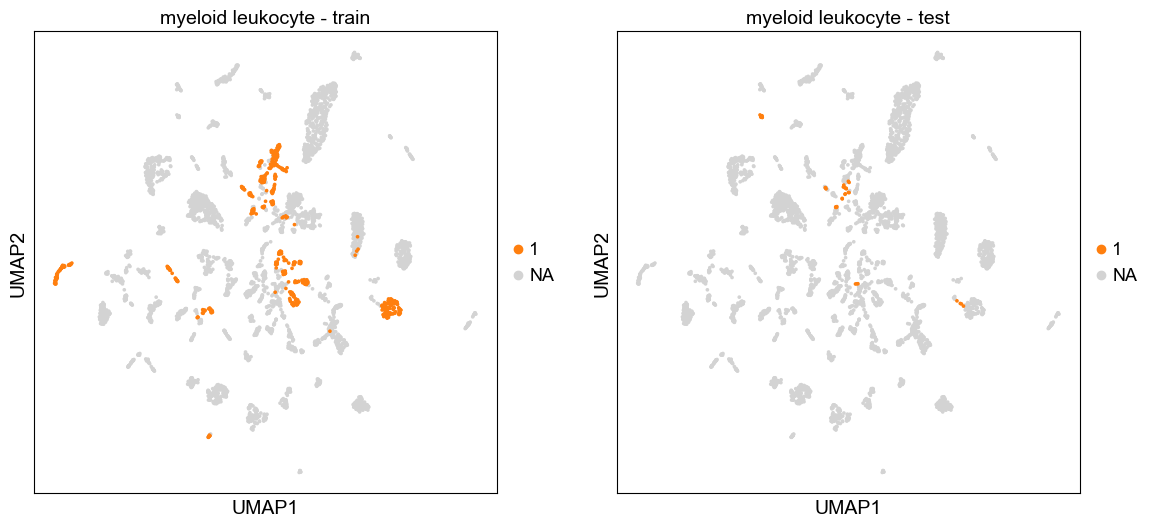

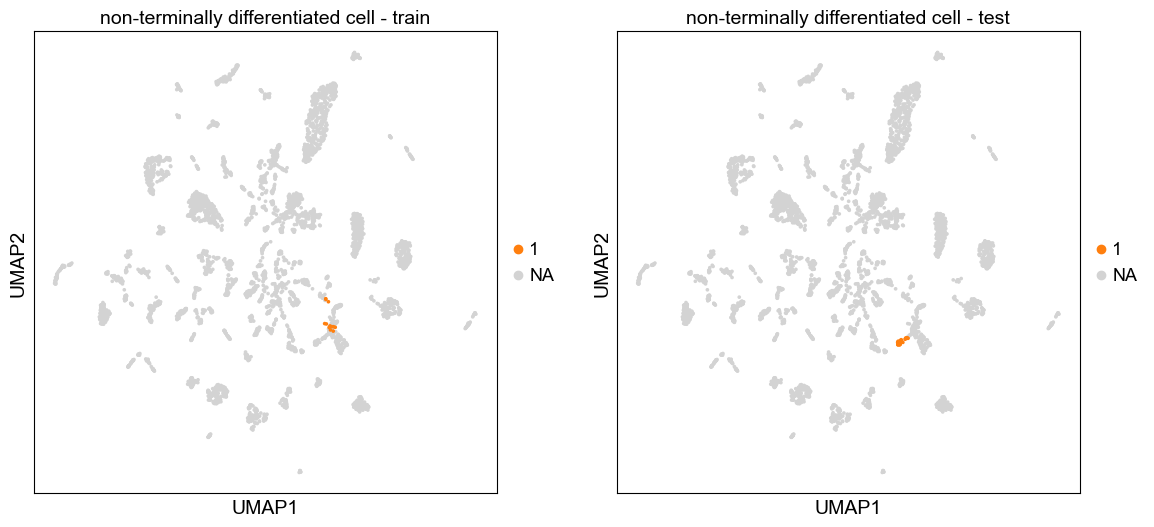

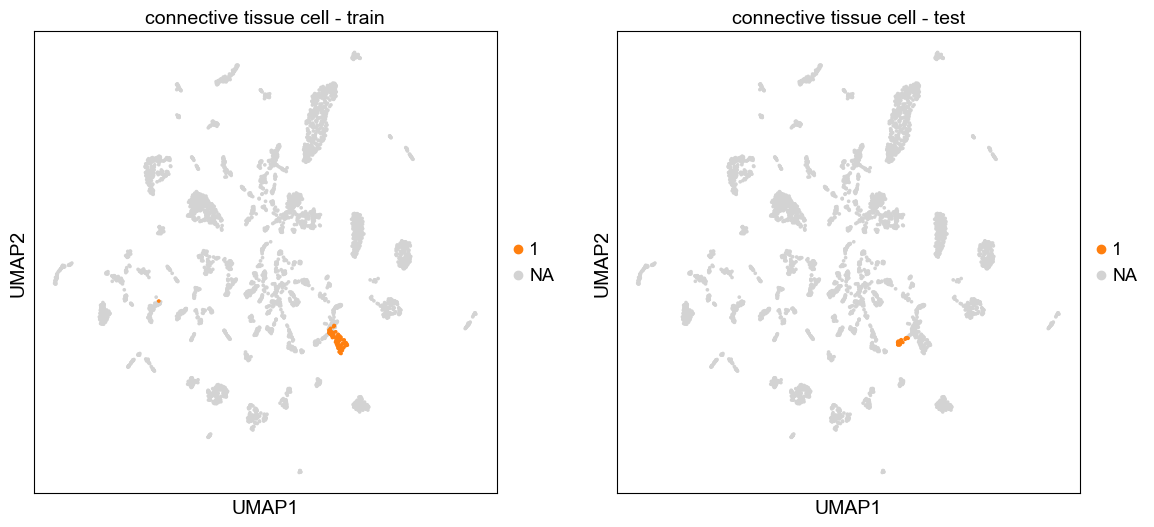

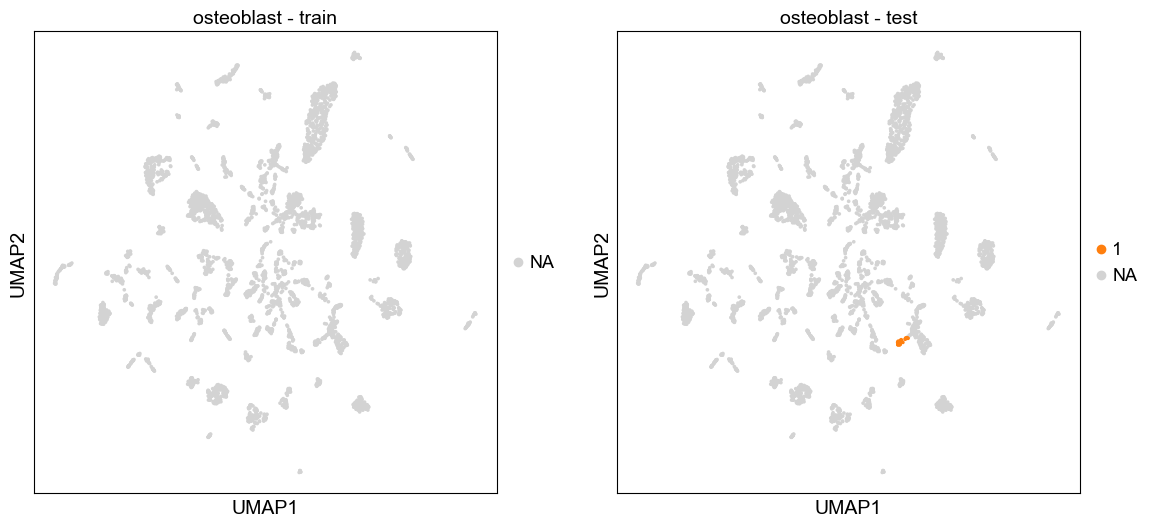

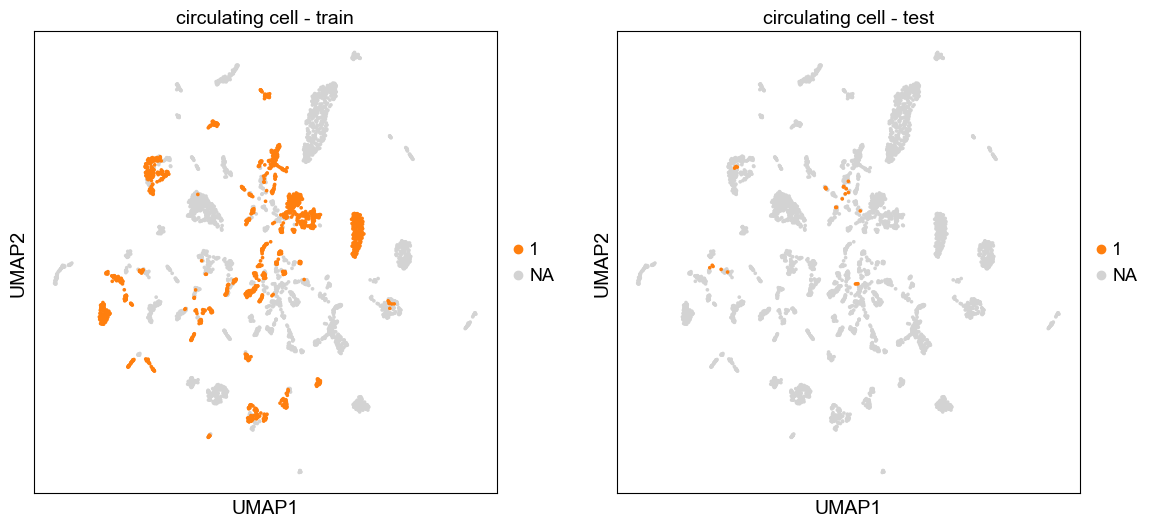

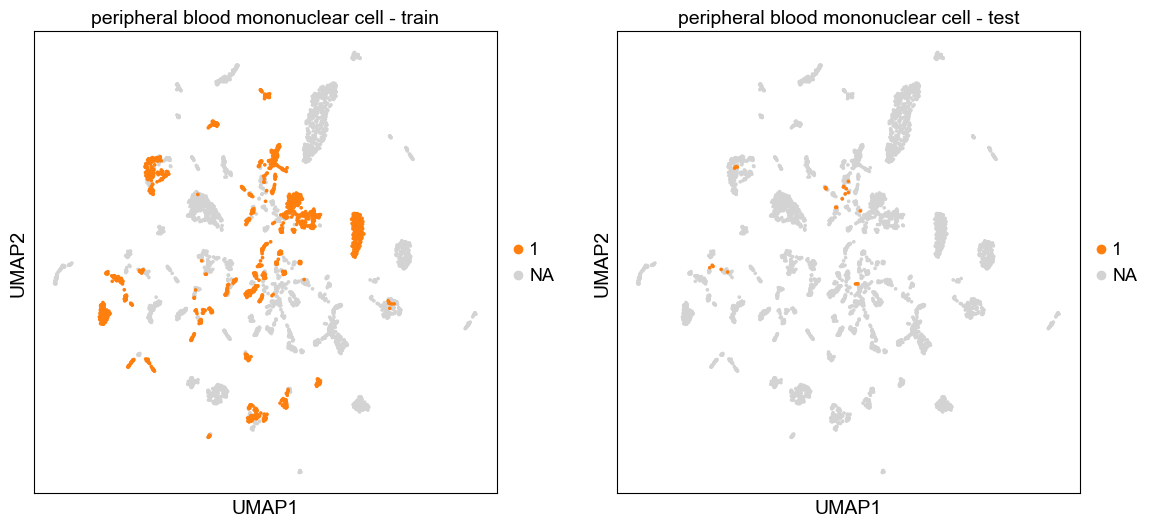

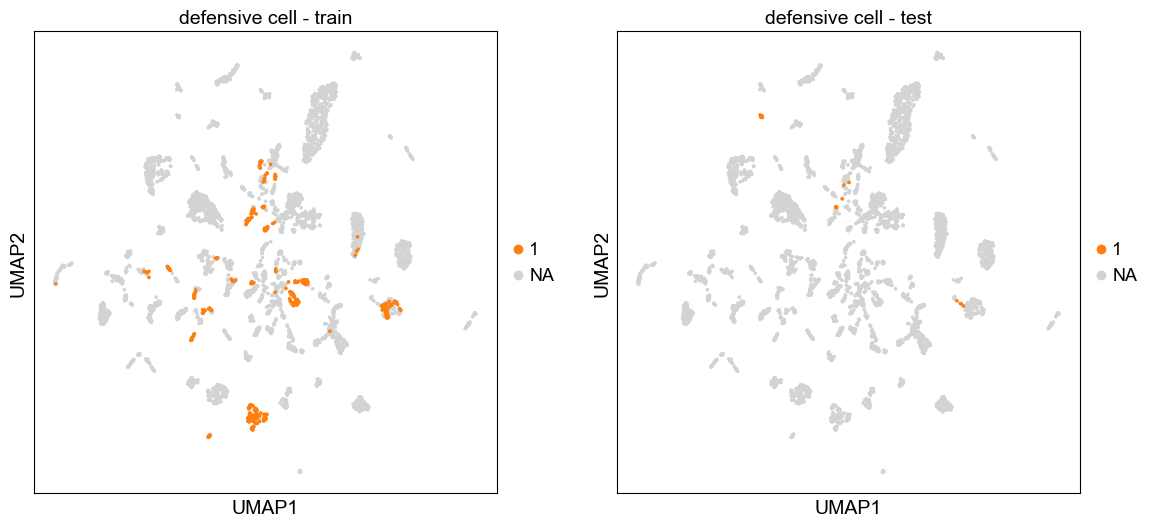

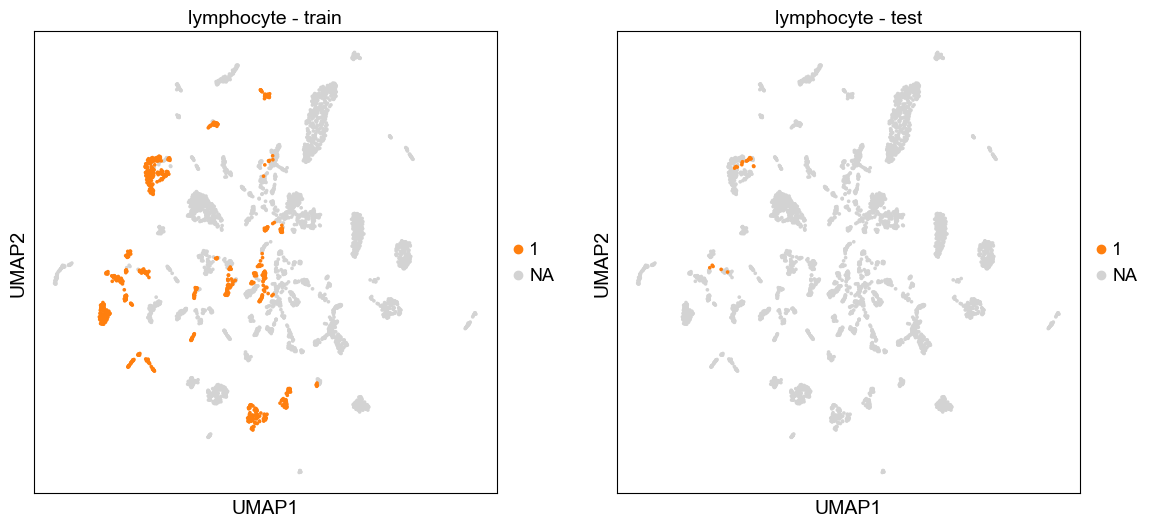

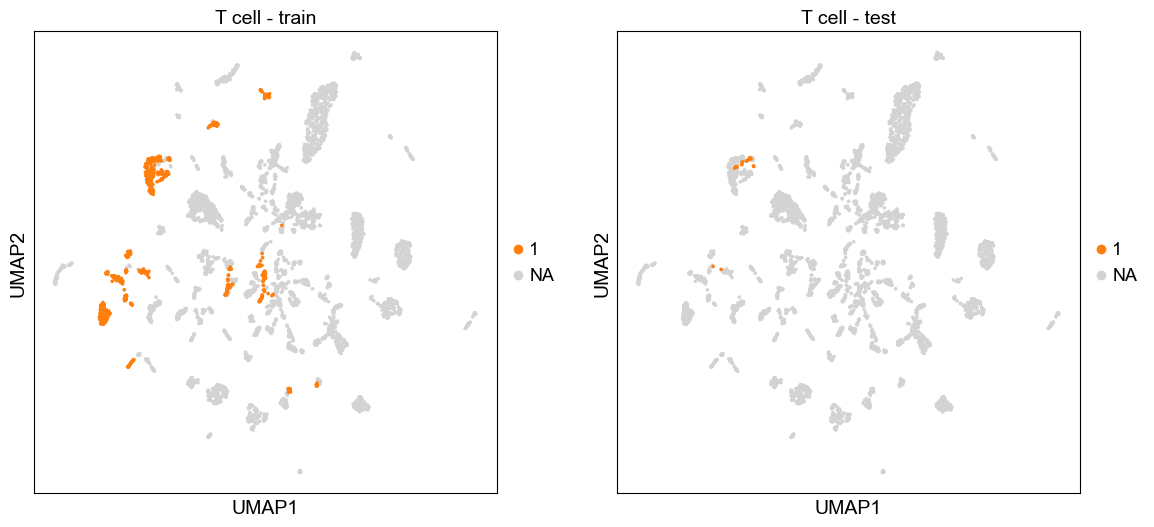

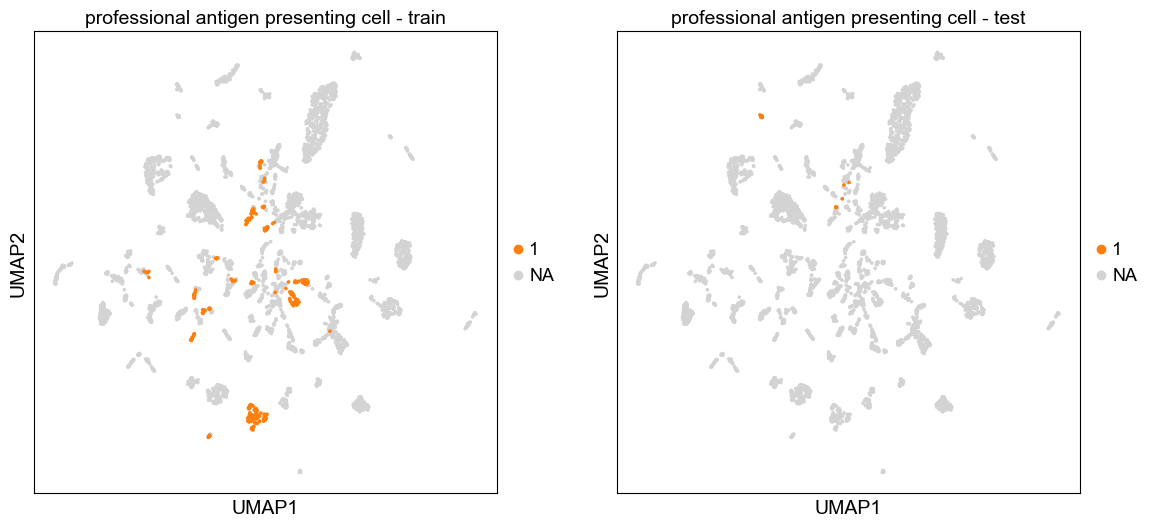

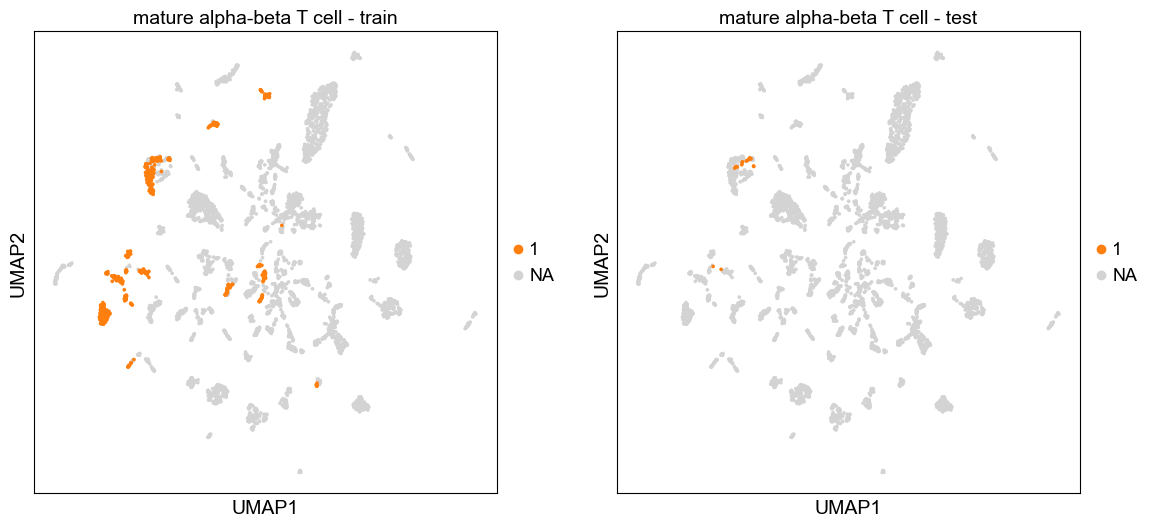

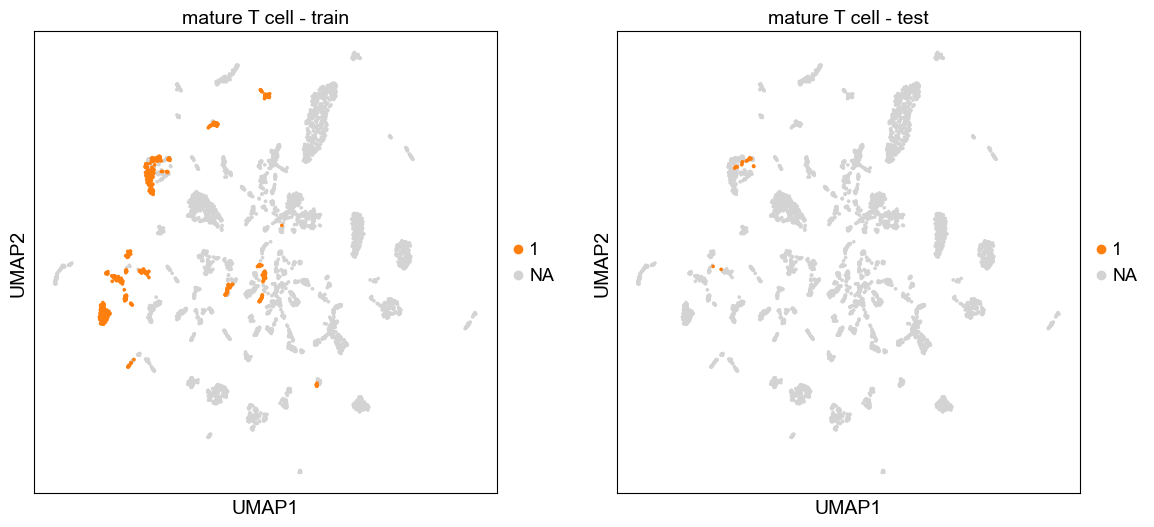

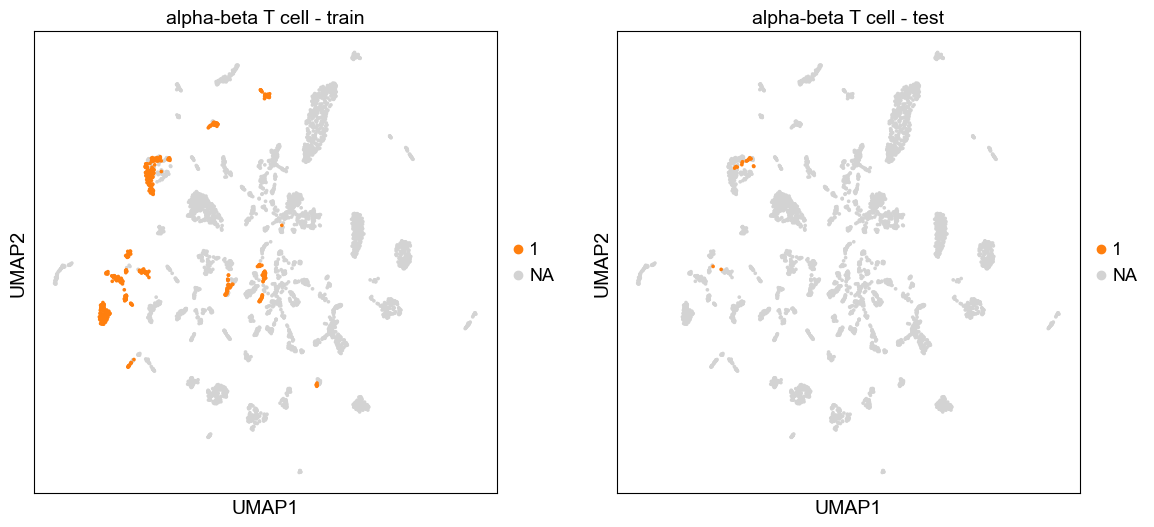

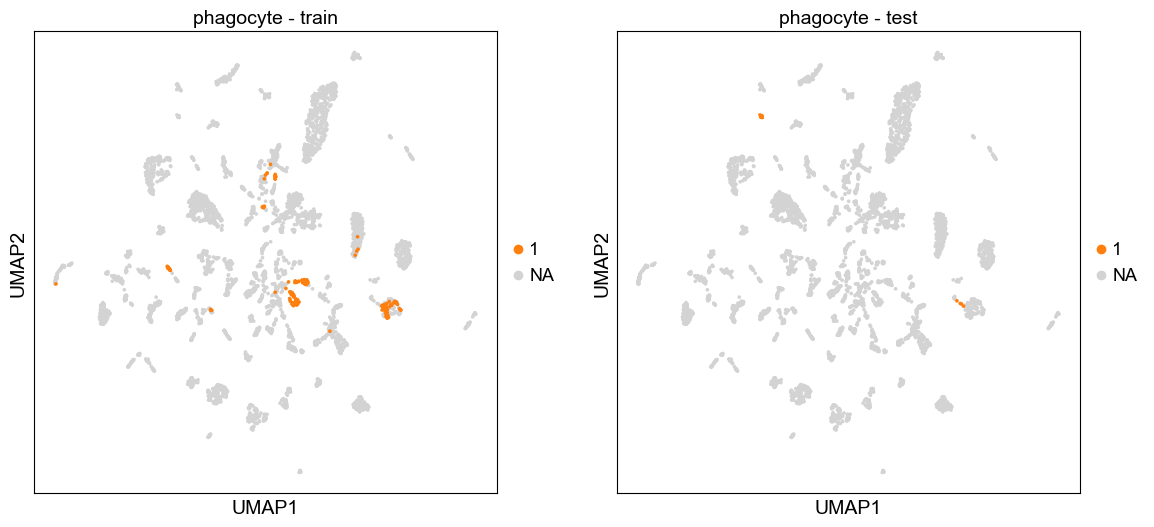

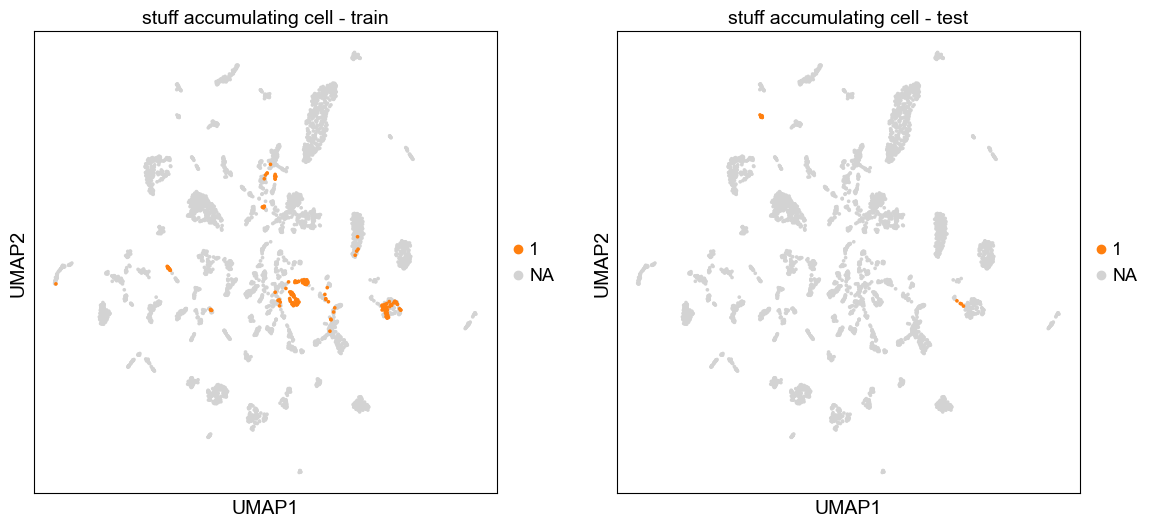

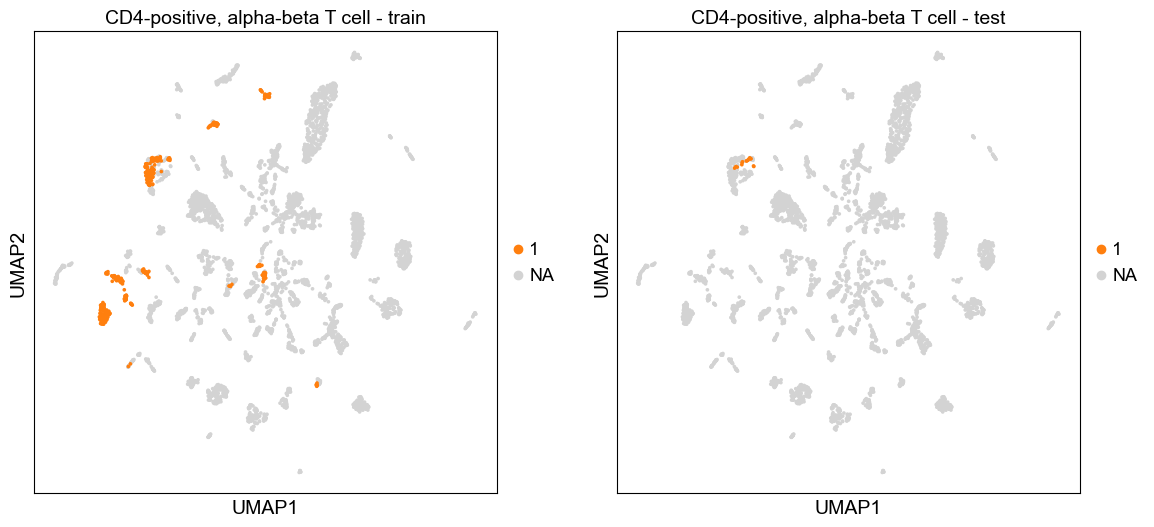

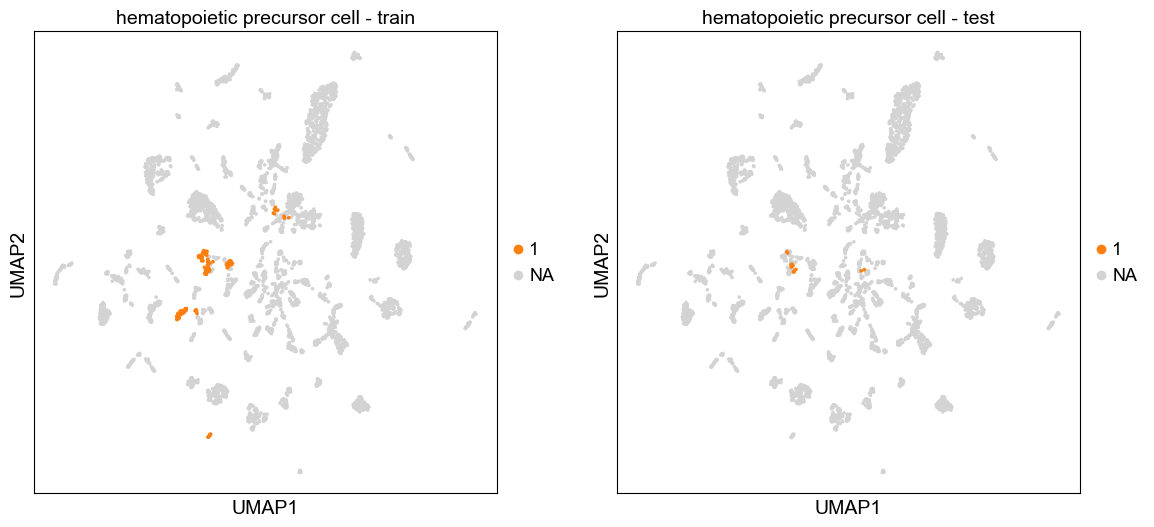

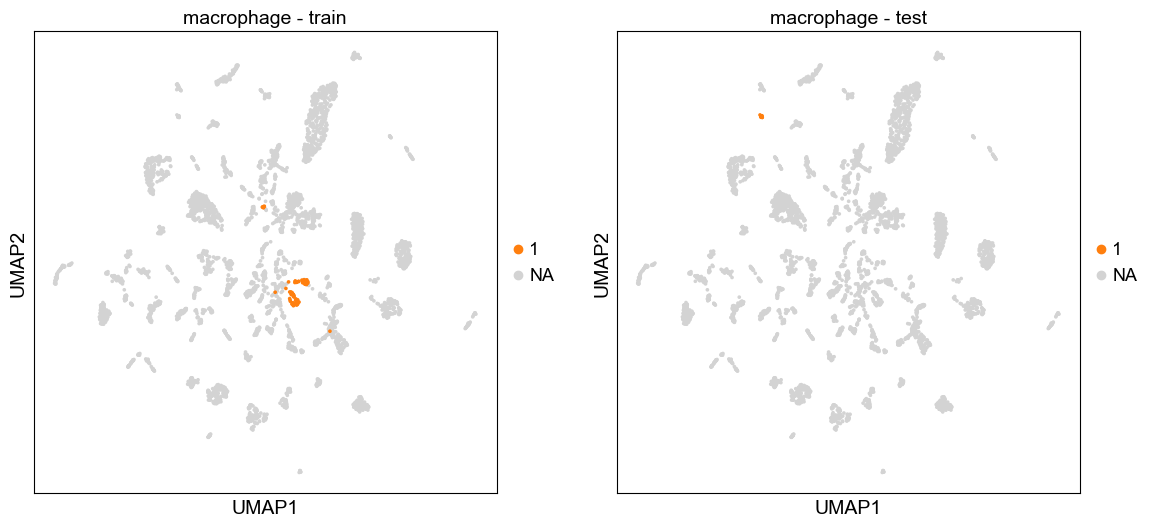

In [68]:
sc.set_figure_params(dpi=100)
plt.rcParams["figure.figsize"] = (6, 6)

for ctype in top_train_types.index:
    sc.pl.umap(ad, color=[ctype + ' - train', ctype + ' - test'], groups=['1'])